In [21]:
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import healpy as hp
from astropy.coordinates import spherical_to_cartesian

In [22]:
# fields_file = 'winter_fields.txt'
# # fields_file = '/Users/viraj/ZTF/ZTF_Fields.txt'
# fields = pd.read_csv(fields_file, delim_whitespace=True)

fields_file = 'WINTER_tiles_indexed_zero_missing.dat'
fields = pd.read_csv(fields_file, delim_whitespace=True)
fields.rename(columns={'ra_center':'RA', 'dec_center':'Dec'}, inplace=True)

In [23]:
full_ra_size_deg= 1 # Verified with dec=0
full_dec_size_deg= 1 # Decs are spaced by 1 deg, so fields are 1 deg.
nx, ny = 1, 1
subimg_half_ra_deg = full_ra_size_deg / (2 * nx)
subimg_half_dec_deg = full_dec_size_deg / (2 * ny)

In [24]:
# Calculating corners as midpoints of the fields grouped by ras
def get_delta_ra_corners(x):
    return (np.ptp(x)/(len(x)-1))/2

half_delta_ra = fields.groupby('Dec')['RA'].apply(get_delta_ra_corners)#.reset_index(drop=True)
decs = half_delta_ra.index

fields['half_delta_ra'] = 0
for d in decs:
    fields['half_delta_ra'][fields['Dec']==d] = half_delta_ra.loc[d]
    
fields['half_delta_dec'] = subimg_half_dec_deg

fields['ra0_0'] = fields['RA'] - fields['half_delta_ra']
fields['dec0_0'] = fields['Dec'] - fields['half_delta_dec']
fields['ra0_1'] = fields['RA'] + fields['half_delta_ra']
fields['dec0_1'] = fields['Dec'] - fields['half_delta_dec']
fields['ra1_0'] = fields['RA'] - fields['half_delta_ra']
fields['dec1_0'] = fields['Dec'] + fields['half_delta_dec']
fields['ra1_1'] = fields['RA'] + fields['half_delta_ra']
fields['dec1_1'] = fields['Dec'] + fields['half_delta_dec']

fields['ra0_0'][fields['ra0_0']<0] += 360
fields['ra0_1'][fields['ra0_1']<0] += 360
fields['ra1_0'][fields['ra1_0']<0] += 360
fields['ra1_1'][fields['ra1_1']<0] += 360


# from sky_tiling import ranked_tiling

# dec_down, dec_up, ra_down_left, ra_down_right, ra_up_left, ra_up_right = ranked_tiling.getTileBounds(1, fields['RA'], fields['Dec'])
# fields['ra0_0'] = ra_up_left
# fields['dec0_0'] = dec_up
# fields['ra0_1'] = ra_up_right
# fields['dec0_1'] = dec_up
# fields['ra1_0'] = ra_down_left
# fields['dec1_0'] = dec_down
# fields['ra1_1'] = ra_down_right
# fields['dec1_1'] = dec_down

/var/folders/zj/ss0wvd7s3nxb2kdbh6g0gccw0000gn/T/ipykernel_6607/3272576994.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fields['half_delta_ra'][fields['Dec']==d] = half_delta_ra.loc[d]
/var/folders/zj/ss0wvd7s3nxb2kdbh6g0gccw0000gn/T/ipykernel_6607/3272576994.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fields['ra0_0'][fields['ra0_0']<0] += 360
/var/folders/zj/ss0wvd7s3nxb2kdbh6g0gccw0000gn/T/ipykernel_6607/3272576994.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [25]:
# galaxies = pd.read_csv('S230518h_galaxies.csv')
galaxies = pd.read_csv('./bns_200Mpc_crossmatched_catalog.csv')
galaxies_crds = SkyCoord(ra=galaxies['ra'], dec=galaxies['dec'], unit=(u.deg,u.deg))

In [26]:
# Calculate total stellar mass and number of galaxies in each WINTER field
contains_flags, mstars, Ngals  = [], [], []
for ind, row in fields.iterrows():
    ra0_0, ra0_1, dec0_0, dec1_0 = row['ra0_0'], row['ra0_1'], row['dec0_0'], row['dec1_0']
    contains_flag = np.zeros(len(galaxies)).astype(bool)
    gals_in_fields = ((galaxies['ra']>ra0_0) & (galaxies['ra']<ra0_1)) & ((galaxies['dec']>dec0_0)&(galaxies['dec']<dec1_0))
    contains_flag[gals_in_fields]= True
    contains_flags.append(contains_flag)
    mstars.append(galaxies[gals_in_fields]['Mstar'].sum())
    Ngals.append(galaxies[gals_in_fields]['ra'].count())
    
fields['Mstars'] = mstars
fields['Ngals'] = Ngals

In [27]:
# Read in the skymap
# prob = hp.read_map('S230518h_rev2_Bilby.multiorder.fits,0_flattened.fits.gz')
prob = hp.read_map('bns_200Mpc_data_flattened.fits.gz')
npix = len(prob)
nside = hp.npix2nside(npix)

In [28]:
# Get probabilities enclosed in each WINTER field
sim_pixs = np.zeros(len(prob))
field_probs = []
for ind, row in fields.iterrows():
    xyzvectors = [spherical_to_cartesian(1, lon=row['ra0_0']*np.pi/180, lat=row['dec0_0']*np.pi/180),
    spherical_to_cartesian(1, lat=row['dec0_1']*np.pi/180, lon=row['ra0_1']*np.pi/180),
    spherical_to_cartesian(1, lon=row['ra1_1']*np.pi/180, lat=row['dec1_1']*np.pi/180),
    spherical_to_cartesian(1, lon=row['ra1_0']*np.pi/180, lat=row['dec1_0']*np.pi/180)]
    ipixs = hp.query_polygon(nside, xyzvectors)
    sim_pixs[ipixs] += 1
    field_probs.append(np.sum(prob[ipixs]))

In [29]:
fields['field_probs'] = field_probs

In [30]:
# Get fields within top 90% probability
skymap_ranked_fields = fields.sort_values('field_probs', ascending=False).reset_index(drop=True)
skymap_ranked_fields['cumprob'] = skymap_ranked_fields['field_probs'].cumsum()
cumprob_id = np.argmin(np.abs(skymap_ranked_fields['cumprob']-0.9))
skymap_90_fields = skymap_ranked_fields.loc[0:cumprob_id]

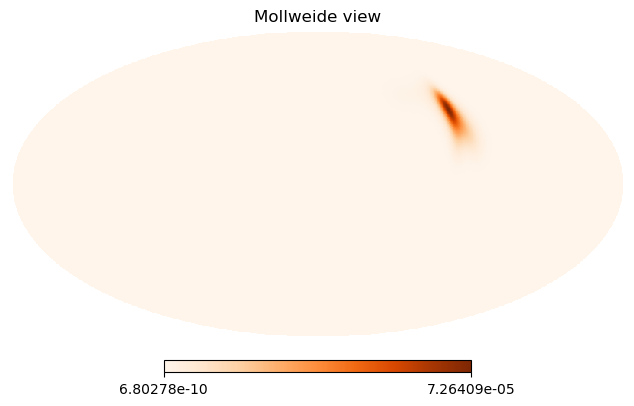

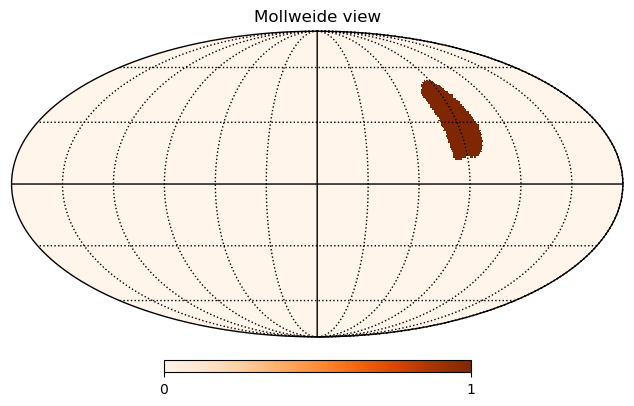

In [31]:
# Just a sanity check - build a healpix map of winter fields within top 90%
sim_pixs = np.zeros(len(prob))
field_probs = []
for ind, row in skymap_90_fields.iterrows():
    xyzvectors = [spherical_to_cartesian(1, lon=row['ra0_0']*np.pi/180, lat=row['dec0_0']*np.pi/180),
    spherical_to_cartesian(1, lat=row['dec0_1']*np.pi/180, lon=row['ra0_1']*np.pi/180),
    spherical_to_cartesian(1, lon=row['ra1_1']*np.pi/180, lat=row['dec1_1']*np.pi/180),
    spherical_to_cartesian(1, lon=row['ra1_0']*np.pi/180, lat=row['dec1_0']*np.pi/180)]
    ipixs = hp.query_polygon(nside, xyzvectors)
    sim_pixs[ipixs] += 1
    field_probs.append(np.sum(prob[ipixs]))
    
# Plot to make sure the WINTER fields within 90% look reasonable
fig = plt.figure()
hp.mollview(prob, cmap='Oranges', fig=fig)

fig = plt.figure()
hp.mollview(sim_pixs, fig=fig, cmap='Oranges')
hp.graticule()

In [32]:
skymap_90_fields

,ID,RA,Dec,half_delta_ra,half_delta_dec,ra0_0,dec0_0,ra0_1,dec0_1,ra1_0,dec1_0,ra1_1,dec1_1,Mstars,Ngals,field_probs,cumprob
0,33115,272.193746,37.0,0.626068,0.5,271.567678,36.5,272.819814,36.5,271.567678,37.5,272.819814,37.5,2.325420e+11,6,0.005941,0.005941
1,33399,271.044135,38.0,0.634509,0.5,270.409626,37.5,271.678644,37.5,270.409626,38.5,271.678644,38.5,5.115680e+11,8,0.005628,0.011570
2,32238,271.389837,34.0,0.603109,0.5,270.786728,33.5,271.992946,33.5,270.786728,34.5,271.992946,34.5,1.752000e+11,4,0.005597,0.017166
3,32239,272.596055,34.0,0.603109,0.5,271.992946,33.5,273.199164,33.5,271.992946,34.5,273.199164,34.5,6.955460e+11,5,0.005564,0.022730
4,32826,271.879043,36.0,0.618034,0.5,271.261009,35.5,272.497077,35.5,271.261009,36.5,272.497077,36.5,1.395829e+11,5,0.005514,0.028243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,30696,258.017407,29.0,0.571677,0.5,257.445730,28.5,258.589084,28.5,257.445730,29.5,258.589084,29.5,4.967742e+11,25,0.000224,0.899046
665,35539,283.469883,46.0,0.719778,0.5,282.750105,45.5,284.189661,45.5,282.750105,46.5,284.189661,46.5,4.876500e+11,9,0.000223,0.899269
666,27757,259.574568,20.0,0.532089,0.5,259.042479,19.5,260.106657,19.5,259.042479,20.5,260.106657,20.5,6.684145e+11,8,0.000223,0.899492
667,25353,266.150097,13.0,0.513152,0.5,265.636945,12.5,266.663249,12.5,265.636945,13.5,266.663249,13.5,1.203150e+11,2,0.000221,0.899713


# New metric : Stellar mass * probability

In [33]:
skymap_90_fields['Mstarstprob'] = skymap_90_fields['Mstars']*skymap_90_fields['field_probs']

/var/folders/zj/ss0wvd7s3nxb2kdbh6g0gccw0000gn/T/ipykernel_6607/2557825708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skymap_90_fields['Mstarstprob'] = skymap_90_fields['Mstars']*skymap_90_fields['field_probs']


Get top 100 pointings sorted by probability, stellar mass or our new stellar-mass-weighted-probability

In [34]:
top100_prob = skymap_90_fields.sort_values('field_probs', ascending=False).reset_index(drop=True).loc[:100]
top100_mass = skymap_90_fields.sort_values('Mstars', ascending=False).reset_index(drop=True).loc[:100]
top100_mtp = skymap_90_fields.sort_values('Mstarstprob', ascending=False).reset_index(drop=True).loc[:100]

In [35]:
top100_prob = skymap_90_fields.sort_values('field_probs', ascending=False).reset_index(drop=True)
top100_mass = skymap_90_fields.sort_values('Mstars', ascending=False).reset_index(drop=True)
top100_mtp = skymap_90_fields.sort_values('Mstarstprob', ascending=False).reset_index(drop=True)

In [36]:
top100_prob['field_probs'].sum(), top100_prob['Mstars'].sum()/skymap_90_fields['Mstars'].sum()

(0.8999336464653885, 1.0)

In [37]:
top100_mass['field_probs'].sum(), top100_mass['Mstars'].sum()/skymap_90_fields['Mstars'].sum()

(0.8999336464653886, 1.0)

In [38]:
top100_mtp['field_probs'].sum(), top100_mtp['Mstars'].sum()/skymap_90_fields['Mstars'].sum()

(0.8999336464653885, 1.0)

# Make a plot!

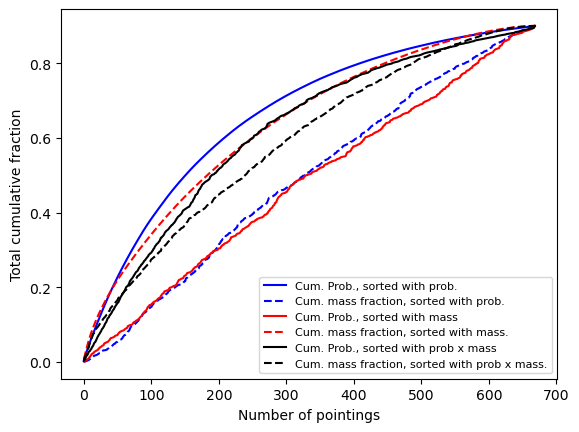

In [39]:
plt.plot(top100_prob['cumprob'], color='blue', label='Cum. Prob., sorted with prob.')
plt.plot(top100_prob['Mstars'].cumsum()*0.9/skymap_90_fields['Mstars'].sum(), color='blue', 
         linestyle='--', label='Cum. mass fraction, sorted with prob.')

plt.plot(top100_mass['field_probs'].cumsum(), color='red', label='Cum. Prob., sorted with mass')
plt.plot(top100_mass['Mstars'].cumsum()*0.9/skymap_90_fields['Mstars'].sum(), color='red', 
         linestyle='--', label='Cum. mass fraction, sorted with mass.')

plt.plot(top100_mtp['field_probs'].cumsum(), color='black', label='Cum. Prob., sorted with prob x mass')
plt.plot(top100_mtp['Mstars'].cumsum()*0.9/skymap_90_fields['Mstars'].sum(), color='black', 
         linestyle='--', label='Cum. mass fraction, sorted with prob x mass.')

plt.xlabel('Number of pointings')
plt.ylabel('Total cumulative fraction')
plt.legend(fontsize=8)